# Derive stand attribute -relationships from multi-source NFI data
Samuli Launiainen Nov 3th, 2022

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
EPS = np.finfo(float).eps
from get_mNFI import sample_mNFI, percentile_dbh_distr

# SLA = {'pine': 5.54, 'spruce': 5.65, 'birch': 18.46}  # m2/kg, Kellomäki et al. 2001 Atm. Env.
SLA = {'pine': 6.8, 'spruce': 4.7, 'birch': 14.0}  # Härkönen et al. 2015 BER 20, 181-195

## Load subset of mNFI data

1. Pine-dominated stands (pine volume / total volume >0.9), mineral soil (maintype=1), sub-xeric (sitetype=4) forests
1. Do the same for spruce-dominated

1. See mNFI description in Readme-2019.txt

In [3]:
# get data from pine-dominated stands (volume fraction >0.9), mineral soil (maintype=1), sub-xeric (sitetype=4) forests
species = ('pine', 0.9)
nfi = sample_mNFI(maintype=1, sitetype=4, species=species)

nfi['LAI'] = 0.001 * nfi['fol'] * SLA[species[0]]


### Data size and variables

In [4]:
N = len(nfi['vol'])
variables = list(nfi.keys())
print('Npixels', N)
print('variables', variables)

Npixels 387971
variables ['maintype', 'sitetype', 'age', 'ba', 'd50', 'height', 'vol', 'vol_p', 'fol', 'f_vol', 'LAI']


### Plot LAI, BA- and age histograms; pure pine stands seem to have low LAI

Text(0.5, 0, 'age (yr)')

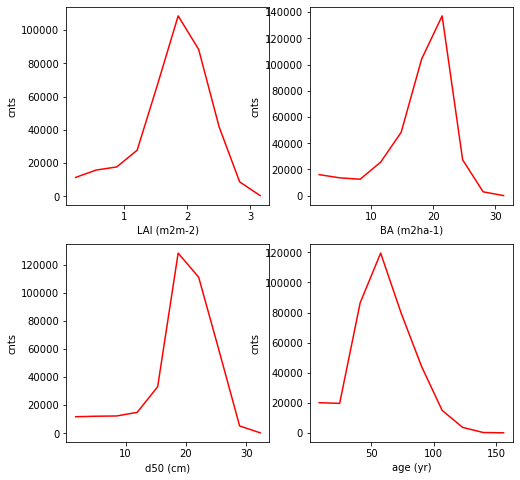

In [5]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(8,8)
#--LAI
a, b = np.histogram(nfi['LAI'])
b = 0.5*(b[1:] + b[0:-1])
ax[0,0].plot(b,a,'r-');
ax[0,0].set_ylabel('cnts')
ax[0,0].set_xlabel('LAI (m2m-2)')

#--ba
a, b = np.histogram(nfi['ba'])
b = 0.5*(b[1:] + b[0:-1])
ax[0,1].plot(b,a,'r-');
ax[0,1].set_ylabel('cnts')
ax[0,1].set_xlabel('BA (m2ha-1)')

#--d50
a, b = np.histogram(nfi['d50'])
b = 0.5*(b[1:] + b[0:-1])
ax[1,0].plot(b,a,'r-');
ax[1,0].set_ylabel('cnts')
ax[1,0].set_xlabel('d50 (cm)')

#--age
a, b = np.histogram(nfi['age'])
b = 0.5*(b[1:] + b[0:-1])
ax[1,1].plot(b,a,'r-');
ax[1,1].set_ylabel('cnts')
ax[1,1].set_xlabel('age (yr)')

## Draw some stand attribute relationships

In [6]:
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter(x , y, ax=None, sort=True, bins=20, axis_labels=['x','y'], **kwargs )   :
    """
    Scatter plot colored by point density from 2d histogram
    from: https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins=bins, density=True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    ax.set_xlabel(axis_labels[0])
    ax.set_ylabel(axis_labels[1])
    
    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = plt.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('point density')

    return ax



## Make point-density colored scatterplots with binned medians in red
### Fit function of form y = a + b * [1 - exp(-cx)] to binned medians; linear model would work fine for some relationships.

In [7]:
from scipy.optimize import curve_fit

def fun1(x, a, b, c):
    #linear
    return a + b* x

def fun2(x, a, b, c):
    #non-linear
    y =  a + b * (1 - np.exp(-c*x))
    return y


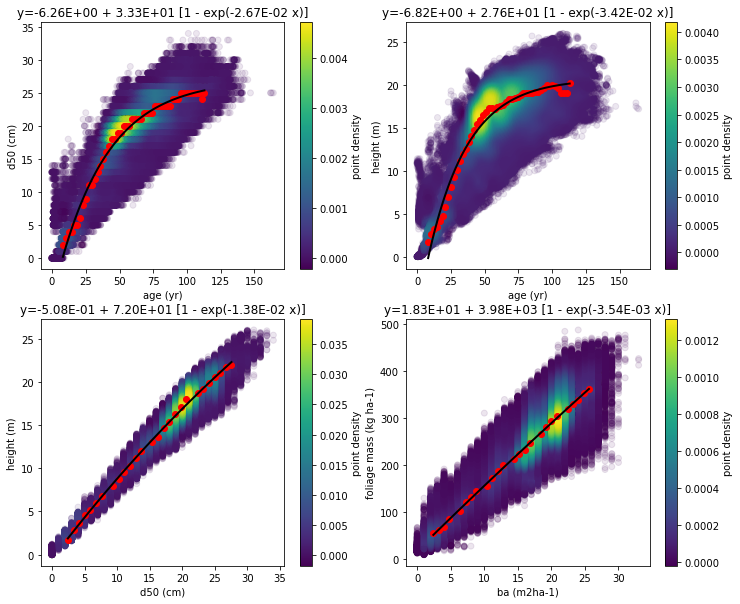

In [8]:
from scipy.stats import binned_statistic
fig, ax = plt.subplots(2,2)
fig.set_size_inches(12, 10)

# -- age -dbh
x = nfi['age']
y = nfi['d50']
density_scatter(x, y, ax[0,0], axis_labels=['age (yr)', 'd50 (cm)'], alpha=0.1)

yb, be, bn = binned_statistic(x, y, statistic='median', bins=50,range=[np.quantile(x, [0.01, 0.99])])
xb = 0.5*(be[0:-1] + be[1:])
ax[0,0].plot(xb, yb, 'ro')

xx = np.linspace(min(xb), max(xb), 100)
# fit and predict
popt, pcov = curve_fit(fun2, xb, yb, p0=np.array([0.0, 3.0, 2.5e-2]))
yf = fun2(xx, *popt)
ax[0,0].plot(xx, yf, 'k-', linewidth=2)
ax[0,0].set_title('y=%.2E + %.2E [1 - exp(-%.2E x)]' % (popt[0], popt[1], popt[2]))

# -- age - height
y = nfi['height']
density_scatter(x, y, ax[0,1], axis_labels=['age (yr)', 'height (m)'], alpha=0.1)
yb, be, bn = binned_statistic(x, y, statistic='median', bins=50,range=[np.quantile(x, [0.01, 0.99])])
f = np.where((np.isfinite(yb)))
xb = 0.5*(be[0:-1] + be[1:])
xb = xb[f]; yb = yb[f]

ax[0,1].plot(xb, yb, 'ro')

# fit
xx = np.linspace(min(xb), max(xb), 100)
# fit and predict
popt, pcov = curve_fit(fun2, xb, yb, p0=np.array([0.0, 3.0, 2.5e-2]))
yf = fun2(xx, *popt)
ax[0,1].plot(xx, yf, 'k-', linewidth=2)
ax[0,1].set_title('y=%.2E + %.2E [1 - exp(-%.2E x)]' % (popt[0], popt[1], popt[2]))


# --- dbh - height
x = nfi['d50']
y = nfi['height']
density_scatter(x, y, ax[1,0], axis_labels=['d50 (cm)', 'height (m)'], alpha=0.1)
yb, be, bn = binned_statistic(x, y, statistic='median', bins=30,range=[np.quantile(x, [0.01, 0.99])])
f = np.where((np.isfinite(yb)))
xb = 0.5*(be[0:-1] + be[1:])
xb = xb[f]; yb = yb[f]

ax[1,0].plot(xb, yb, 'ro')

# fit
xx = np.linspace(min(xb), max(xb), 100)
# fit and predict
popt, pcov = curve_fit(fun2, xb, yb, p0=np.array([0.0, 3.0, 2.5e-2]))
yf = fun2(xx, *popt)
ax[1,0].plot(xx, yf, 'k-', linewidth=2)
ax[1,0].set_title('y=%.2E + %.2E [1 - exp(-%.2E x)]' % (popt[0], popt[1], popt[2]))

#--- ba - foliage mass
x = nfi['ba']
y = nfi['fol']
density_scatter(x, y, ax[1,1], axis_labels=['ba (m2ha-1)', 'foliage mass (kg ha-1)'], alpha=0.1)
yb, be, bn = binned_statistic(x, y, statistic='median', bins=30,range=[np.quantile(x, [0.01, 0.99])])
f = np.where((np.isfinite(yb)))
xb = 0.5*(be[0:-1] + be[1:])
xb = xb[f]; yb = yb[f]

ax[1,1].plot(xb, yb, 'ro')

# fit
xx = np.linspace(min(xb), max(xb), 100)
# fit and predict
popt, pcov = curve_fit(fun2, xb, yb, p0=np.array([0.0, 3.0, 2.5e-2]))
yf = fun2(xx, *popt)
ax[1,1].plot(xx, yf, 'k-', linewidth=2)
ax[1,1].set_title('y=%.2E + %.2E [1 - exp(-%.2E x)]' % (popt[0], popt[1], popt[2]))

plt.show()

In [9]:
fig.savefig(r'Results/mNFI_Pine_sub-xeric_relationships.png')

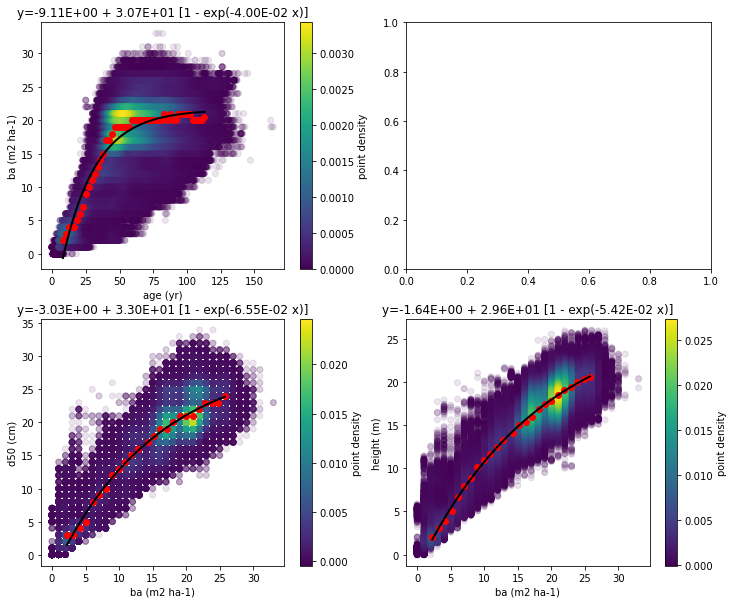

In [16]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(12, 10)

# -- age -ba
x = nfi['age']
y = nfi['ba']
density_scatter(x, y, ax[0,0], axis_labels=['age (yr)', 'ba (m2 ha-1)'], alpha=0.1)

yb, be, bn = binned_statistic(x, y, statistic='median', bins=50,range=[np.quantile(x, [0.01, 0.99])])
xb = 0.5*(be[0:-1] + be[1:])
ax[0,0].plot(xb, yb, 'ro')

xx = np.linspace(min(xb), max(xb), 100)
# fit and predict
popt, pcov = curve_fit(fun2, xb, yb, p0=np.array([0.0, 3.0, 2.5e-2]))
yf = fun2(xx, *popt)
ax[0,0].plot(xx, yf, 'k-', linewidth=2)
ax[0,0].set_title('y=%.2E + %.2E [1 - exp(-%.2E x)]' % (popt[0], popt[1], popt[2]))

# -- ba - d50

x = nfi['ba']
y = nfi['d50']
density_scatter(x, y, ax[1,0], axis_labels=['ba (m2 ha-1)', 'd50 (cm)'], alpha=0.1)
yb, be, bn = binned_statistic(x, y, statistic='median', bins=50,range=[np.quantile(x, [0.01, 0.99])])
f = np.where((np.isfinite(yb)))
xb = 0.5*(be[0:-1] + be[1:])
xb = xb[f]; yb = yb[f]

ax[1,0].plot(xb, yb, 'ro')

# fit
xx = np.linspace(min(xb), max(xb), 100)
# fit and predict
popt, pcov = curve_fit(fun2, xb, yb, p0=np.array([0.0, 3.0, 2.5e-2]))
yf = fun2(xx, *popt)
ax[1,0].plot(xx, yf, 'k-', linewidth=2)
ax[1,0].set_title('y=%.2E + %.2E [1 - exp(-%.2E x)]' % (popt[0], popt[1], popt[2]))

# -- ba - height

x = nfi['ba']
y = nfi['height']
density_scatter(x, y, ax[1,1], axis_labels=['ba (m2 ha-1)', 'height (m)'], alpha=0.1)
yb, be, bn = binned_statistic(x, y, statistic='median', bins=50,range=[np.quantile(x, [0.01, 0.99])])
f = np.where((np.isfinite(yb)))
xb = 0.5*(be[0:-1] + be[1:])
xb = xb[f]; yb = yb[f]

ax[1,1].plot(xb, yb, 'ro')

# fit
xx = np.linspace(min(xb), max(xb), 100)
# fit and predict
popt, pcov = curve_fit(fun2, xb, yb, p0=np.array([0.0, 3.0, 2.5e-2]))
yf = fun2(xx, *popt)
ax[1,1].plot(xx, yf, 'k-', linewidth=2)
ax[1,1].set_title('y=%.2E + %.2E [1 - exp(-%.2E x)]' % (popt[0], popt[1], popt[2]))

plt.show()

# Notes for fire-modeling & coupling with SpaFHy & BA-growth model:

### Fire model: 
1. Age-effect is to represent the tree size (height, dbh) and amount and quality of fuels. More relevant for management would be to use tree size (height or dbh) and basal area (or stand volume) to represent 'age' effect. 

1. What the Density-effect actually represents in fire spread model is not clear. Is it tree-to-tree distance, or combined effect of fuel amount and tree-to-tree distance? If we use density in fire model, it linking it with basal area and tree size requires we assume certain diameter-distribution in the stand; see next section.

1. Should we think further and how we can best couple fire model with the BA-growth model? How the fire model should be structured to minimize conversions among BA - tree density - age etc. And, to make it directly usable with the data we have. What is the underlying assumption of dbh-distribution and basal area in Goude et al. 2022?

1. We could do better in fuel quality & quantity if we want to make a progress on that front: from data or allometric relations we can predict wood, branch, dead branch etc. biomasses for all stands, and use stand attributes to derive robust estimates of the amount of dead wood and mosses etc. in different stands.

### SpaFHy:

1. LAI (= foliage mass / area * specific leaf-area) is the key parameter the model results are most sensitive to. Height & canopy closure are 'input parameters' but can be set constant with much impact. Thus, for SpaFHy we just need LAI that is representative for each stand we want to simulate. 

1. The LAI for SpaFHy can be obtained either from dbh-distribution: compute foliage mass of each tree size, scale with tree density / area and sum to stand leaf mass, convert to LAI. Or: use simple regression between basal area and leaf mass (see below)

1. We simulate transpiration, ET, soil water potential etc. (and moss & dead fuel moisture later on?) for different stands, covering 4 dimensions: LAI [0.5...7.0]; conifer/deciduous fraction; soil type [mineral/organic or several mineral/organic]; TWI. 

### BA-growth model:

1. requires initial basal area and tree density as inputs (+ climate).

1. outputs new basal area estimate for each timestep; after growth do management (modify BA and underlying dhb-distribution)

1. how to obtain tree dbh and height from BA? As seen above, these can be whatever... as forests are managed.

### Live fuel:

1. SpaFHy-provided daily transpiration, soil water potential, VPD etc. Height does not much affect transpiration but does so on leaf water potential. So let's drop height from SpaFHy 'lookup-table'.

### Dead fuel:
1. Currently driven just by meteorological inputs (VPD); we can modify 'tau' to account for weaker (energy-limited) evaporation rate in dense stands. Will add Equilibrium evaporation rate (Priestley-Taylor) at forest floor to SpaFHy -inputs

1. Will output 'organic layer', i.e. moss layer water content.

1. Todo: revise whole moisture budget for ground fuels (litter, moss). The coarser dead fuels are never soil-water affected unless submerged?

## Testing ideas to link tree density and basal area. The mNFI-data contains variable 'd50 (cm)' and 'ba (m2 ha-1)'.

From Readme:

The mean diameter of trees is assessed (at 1cm intervals) at height of 1.3 metres and is the the diameter of the basal area median tree. It is about the same as the weighted average diameter, the basal area of a tree as the weight.

*Kangas A. & Maltamo, M. 2000. Silva Fennica: Present robust models for predicting the dbh-distribution from stand attributes using 'percentile distributions' derived for pine, spruce and birch.* See /Literature folder.

The stand attributes used are all available in mNFI: d50, age, basal area (G), soil (0/1; 1 for mesic & poorer sites).

### Compare how total tree density = sum(dbh_i) at the pixels varies if we assume: 

1. distribution where all trees dbh = d50
2. more realistic dbh-distribution following Kangas & Maltamo.  


In [30]:
# obtain dbh-distribution from BA and d50
from get_mNFI import percentile_dbh_distr

def constant_distr(d50, G):
    # all trees same size 
    tree_ba= np.pi * (0.005*d50)**2 # m2
    n = G / (tree_ba + EPS)
    # clearcuts cause noise; set n to zero
    n[d50<1.0] = 0.0
    return n
 
# take random subset of pixels
cnts = 10000
k = np.random.randint(0, len(nfi['d50']), size=cnts)

# sample from nfi data
d50 = nfi['d50'][k] # cm
age = nfi['age'][k] # yr
G = nfi['ba'][k] # m2 ha-1
soil = 1 # dummy, 1 for mesic & poorer, 0 otherwise

# extract dbh frequency for these intervals; omit trees smaller than 2cm 
d_out = np.arange(2.0, 50.0, 2.0)

# call distributions, return: d - bin centers (array), n - distributions (len(d) x k array), N - trees ha-1
d, n, N = percentile_dbh_distr('pine', d50, G, age, soil, d_out)
Nu = constant_distr(d50, G)

Text(0, 0.5, 'true/uniform -ratio')

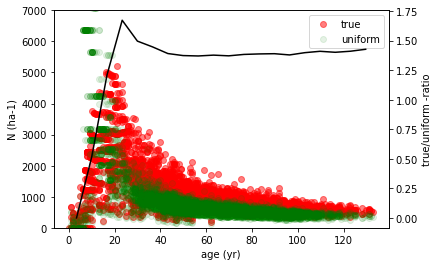

In [31]:
fig, ax = plt.subplots(1)
ax.plot(age, N, 'ro', alpha=0.5, label='true')
ax.plot(age, Nu, 'go', alpha=0.1, label='uniform')
ax.legend()
ax.set_ylim([0, 7000])
ax.set_ylabel('N (ha-1)')
ax.set_xlabel('age (yr)')

# compute N/N0 ratio using of binned medians and plot to right y-axis
yb, be, bn = binned_statistic(age, N/(Nu + EPS), statistic='median',
                              bins=20)
xb = 0.5*(be[0:-1] + be[1:])
axb = ax.twinx()
axb.plot(xb, yb, 'k-')
#axb.set_ylim([0, 1])
axb.set_ylabel('true/uniform -ratio')

Assuming uniform distribution where dbh = d50 underestimates 'true' distribution; ratio N/N0~1.4 in established stands. Turning point in 'true' at ca. 20 yr; most likely mNFI overestimates d50 in young stands?  
### Let's check how the predicted distributions may look like; take small rando, sample from our subset of data

Text(0.5, 0, 'dbh (cm)')

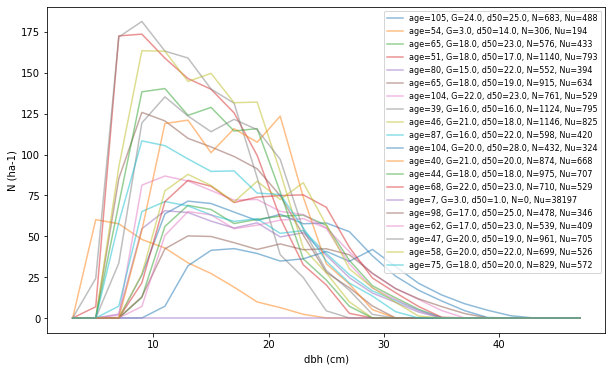

In [35]:
cnts = 20
ix = np.random.randint(0, len(N), size=cnts)

fig4, ax = plt.subplots()
fig4.set_size_inches(10,6)

for j in ix:
    ax.plot(d, n[:,j], '-', alpha=0.5, 
            label='age=%d, G=%.1f, d50=%.1f, N=%d, Nu=%d' % ( age[j], G[j], d50[j], N[j], Nu[j]))

ax.legend(fontsize=8)
ax.set_ylabel('N (ha-1)')
ax.set_xlabel('dbh (cm)')

## Re-sample

Text(0.5, 0, 'dbh (cm)')

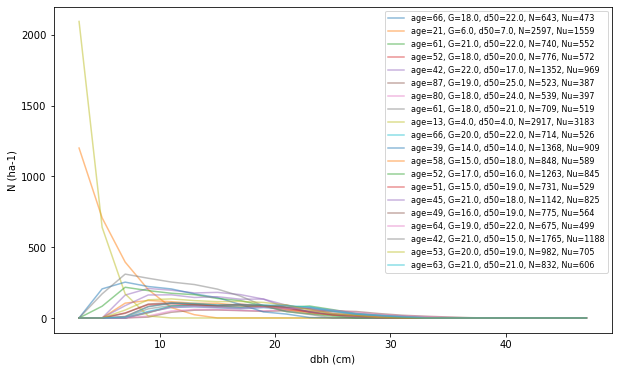

In [37]:
cnts = 20
ix = np.random.randint(0, len(N), size=cnts)

fig4, ax = plt.subplots()
fig4.set_size_inches(10,6)

for j in ix:
    ax.plot(d, n[:,j], '-', alpha=0.5, 
            label='age=%d, G=%.1f, d50=%.1f, N=%d, Nu=%d' % ( age[j], G[j], d50[j], N[j], Nu[j]))

ax.legend(fontsize=8)
ax.set_ylabel('N (ha-1)')
ax.set_xlabel('dbh (cm)')